In [208]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
import json
import nltk
import unicodedata
import re
import string
import joblib as joblib
import pickle as pickle

In [209]:
# Load data
data_train = pd.read_csv('../Dataset/train_data.csv')
data_test = pd.read_csv('../Dataset/test_data.csv')

In [210]:
X_train = data_train['article']
y_train = data_train['label']

X_test = data_test['article']
y_test = data_test['label']

In [211]:
# Text preprocessing
def wordopt(text):
    text = text.lower()
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W", " ", text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

ps = PorterStemmer()
with open('../Resources/stopwords-tl.json', 'r') as f:
    stopwords = json.load(f)

def preprocess(text):
    text = wordopt(text)
    tokens = nltk.word_tokenize(text)
    stems = [ps.stem(token) for token in tokens]
    filtered = [stem for stem in stems if stem not in stopwords]
    return filtered

In [212]:
# Apply preprocess function to X_train
X_train = X_train.apply(preprocess)

# Apply preprocess function to X_test
X_test = X_test.apply(preprocess)

In [213]:
# Convert the preprocessed text into a list of strings
X_train_processed = [' '.join(tokens) for tokens in X_train]
X_test_processed = [' '.join(tokens) for tokens in X_test]

# Initialize the TfidfVectorizer
tfidf_vectorizer = joblib.load('../Models/Vectorizer/vectorizer_lr_27872.joblib')

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.transform(X_train_processed)

# Transform the validation data using the same vectorizer
X_test_tfidf = tfidf_vectorizer.transform(X_test_processed)

# Print the shape of the TF-IDF matrices (No of rows, No of columns)
print("Shape of X_train_tfidf:", X_train_tfidf.shape)
print("Shape of X_test_tfidf:", X_test_tfidf.shape)

Shape of X_train_tfidf: (2103, 27872)
Shape of X_test_tfidf: (902, 27872)


In [214]:
# Save the TfidfVectorizer using joblib
# joblib.dump(tfidf_vectorizer, '../Models/Vectorizer/vectorizer_27872.joblib')

In [215]:
# Initializing base models

mnb = MultinomialNB()
lr = LogisticRegression(max_iter=1000)
rf = RandomForestClassifier()
knn = KNeighborsClassifier()
svm = SVC(probability=True)

TRAINING THE BASE MODELS + HYPERPARAMETER TUNING

1. LOGISTIC REGRESSION (LR)

In [216]:
# Define the parameter grid
param_grid = {'penalty': ['l1', 'l2'], 'C': [1, 10, 100, 1000], 'solver': ['liblinear', 'saga']}

# Define the GridSearchCV
lr_grid = GridSearchCV(estimator=lr, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)
lr_grid.fit(X_train_tfidf, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'C': [1, 10, 100, 1000], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring='accuracy')

2. MNB

In [217]:
# Define the parameter grid
param_grid_mnb = {
    'alpha': [0.1, 0.5, 1.0],               # Additive smoothing parameter
    'fit_prior': [True, False]              # Whether to learn class prior probabilities
}

# Define the GridSearchCV
mnb_grid = GridSearchCV(estimator=mnb, param_grid=param_grid_mnb, scoring='accuracy', cv=5, n_jobs=-1)
mnb_grid.fit(X_train_tfidf, y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.1, 0.5, 1.0], 'fit_prior': [True, False]},
             scoring='accuracy')

3. RF

In [218]:
# Define the parameter grid
param_grid_rf = {
    'n_estimators': [100, 200, 300],         # Number of trees in the forest
    'max_depth': [None, 10, 20],              # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],          # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4]             # Minimum number of samples required at each leaf node
}

# Define the GridSearchCV
rf_grid = GridSearchCV(estimator=rf, param_grid=param_grid_rf, scoring='accuracy', cv=5, n_jobs=-1)
rf_grid.fit(X_train_tfidf, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

4. KNN

In [219]:
# Define the parameter grid
param_grid_knn = {
    'n_neighbors': [3, 5, 7],                # Number of neighbors to use
    'weights': ['uniform', 'distance'],      # Weight function used in prediction
    'p': [1, 2]                               # Power parameter for the Minkowski distance
}

# Define the GridSearchCV
knn_grid = GridSearchCV(estimator=knn, param_grid=param_grid_knn, scoring='accuracy', cv=5, n_jobs=-1)
knn_grid.fit(X_train_tfidf, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [3, 5, 7], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

5. SVM

In [220]:
# Define the parameter grid
param_grid_svm = {
    'C': [0.1, 1, 10],                       # Regularization parameter
    'kernel': ['linear', 'rbf'],             # Kernel type to be used
    'gamma': ['scale', 'auto']               # Kernel coefficient for 'rbf' kernel
}

# Define the GridSearchCV
svm_grid = GridSearchCV(estimator=svm, param_grid=param_grid_svm, scoring='accuracy', cv=5, n_jobs=-1)
svm_grid.fit(X_train_tfidf, y_train)

GridSearchCV(cv=5, estimator=SVC(probability=True), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf']},
             scoring='accuracy')

In [221]:
# Save the base models
joblib.dump(lr_grid, '../Models/Grid/Base Models/lr_grid.joblib')
joblib.dump(mnb_grid, '../Models/Grid/Base Models/mnb_grid.joblib')
joblib.dump(rf_grid, '../Models/Grid/Base Models/rf_grid.joblib')
joblib.dump(knn_grid, '../Models/Grid/Base Models/knn_grid.joblib')
joblib.dump(svm_grid, '../Models/Grid/Base Models/svm_grid.joblib')

['../Models/Grid/Base Models/svm_grid.joblib']

In [222]:
print('===== MNB =====')
print("Best Hyperparameters: ", mnb_grid.best_params_)
print("Best Accuracy: {:.2f}%".format(mnb_grid.best_score_ * 100))

print('===== LR =====')
print("Best Hyperparameters: ", lr_grid.best_params_)
print("Best Accuracy: {:.2f}%".format(lr_grid.best_score_ * 100))

print('===== RF =====')
print("Best Hyperparameters: ", rf_grid.best_params_)
print("Best Accuracy: {:.2f}%".format(rf_grid.best_score_ * 100))

print('===== kNN =====')
print("Best Hyperparameters: ", knn_grid.best_params_)
print("Best Accuracy: {:.2f}%".format(knn_grid.best_score_ * 100))

print('===== SVM =====')
print("Best Hyperparameters: ", svm_grid.best_params_)
print("Best Accuracy: {:.2f}%".format(svm_grid.best_score_ * 100))

===== MNB =====
Best Hyperparameters:  {'alpha': 0.1, 'fit_prior': False}
Best Accuracy: 90.63%
===== LR =====
Best Hyperparameters:  {'C': 100, 'penalty': 'l2', 'solver': 'saga'}
Best Accuracy: 95.20%
===== RF =====
Best Hyperparameters:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best Accuracy: 93.49%
===== kNN =====
Best Hyperparameters:  {'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
Best Accuracy: 86.49%
===== SVM =====
Best Hyperparameters:  {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Best Accuracy: 95.10%


In [223]:
# ===== MNB =====
# Best Hyperparameters:  {'alpha': 0.1, 'fit_prior': True}
# Best Accuracy: 89.16%
# ===== LR =====
# Best Hyperparameters:  {'C': 1000, 'penalty': 'l2', 'solver': 'saga'}
# Best Accuracy: 94.25%
# ===== RF =====
# Best Hyperparameters:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
# Best Accuracy: 93.34%
# ===== RF v2 =====
# Best Hyperparameters:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
# Best Accuracy: 93.20%
# ===== kNN =====
# Best Hyperparameters:  {'n_neighbors': 7, 'p': 2, 'weights': 'uniform'}
# Best Accuracy: 84.83%
# ===== SVM =====
# Best Hyperparameters:  {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
# Best Accuracy: 93.91%

In [224]:
# Save the lr_grid using joblib
joblib.dump(lr_grid, '../Models/Grid/grid_lr.joblib')

['../Models/Grid/grid_lr.joblib']

In [226]:
best_meta = joblib.load('../Models/Grid/grid_mlp_2.joblib').best_estimator_

In [227]:
estimatorss = [
    ('lr', joblib.load('../Models/Grid/Base Models/lr_grid.joblib').best_estimator_),
    ('mnb', joblib.load('../Models/Grid/Base Models/mnb_grid.joblib').best_estimator_),
    ('rf', joblib.load('../Models/Grid/Base Models/rf_grid.joblib').best_estimator_),
    ('knn', joblib.load('../Models/Grid/Base Models/knn_grid.joblib').best_estimator_),
    ('svm', joblib.load('../Models/Grid/Base Models/svm_grid.joblib').best_estimator_)
]

estimatorS = [
    ('mnb', mnb_grid),
    ('lr', lr_grid),
    ('rf', rf_grid),
    ('knn', knn_grid),
    ('svm', svm_grid)
]

In [228]:
rff = joblib.load('../Models/Grid/grid_rf_5_final.joblib').best_estimator_

In [229]:
print(rff)

RandomForestClassifier(min_samples_split=5, n_estimators=400)


In [230]:
# Create StackingClassifier
stack = StackingClassifier(estimators=estimatorss, final_estimator=best_meta, cv='prefit')

# Fit StackingClassifier
stack.fit(X_train_tfidf, y_train)

StackingClassifier(cv='prefit',
                   estimators=[('lr',
                                LogisticRegression(C=100, max_iter=1000,
                                                   solver='saga')),
                               ('mnb',
                                MultinomialNB(alpha=0.1, fit_prior=False)),
                               ('rf',
                                RandomForestClassifier(min_samples_split=5,
                                                       n_estimators=200)),
                               ('knn', KNeighborsClassifier(n_neighbors=3)),
                               ('svm',
                                SVC(C=10, kernel='linear', probability=True))],
                   final_estimator=MLPClassifier(activation='tanh', alpha=0.01,
                                                 hidden_layer_sizes=(10,),
                                                 max_iter=100, solver='lbfgs'))

In [231]:

base_names = ['lr', 'mnb', 'rf', 'knn', 'svm']


lr:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1-score: 1.0000
  ROC AUC: 1.0000
  Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1047
           1       1.00      1.00      1.00      1056

    accuracy                           1.00      2103
   macro avg       1.00      1.00      1.00      2103
weighted avg       1.00      1.00      1.00      2103

mnb:
  Accuracy: 0.9919
  Precision: 0.9906
  Recall: 0.9934
  F1-score: 0.9920
  ROC AUC: 0.9919
  Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1047
           1       0.99      0.99      0.99      1056

    accuracy                           0.99      2103
   macro avg       0.99      0.99      0.99      2103
weighted avg       0.99      0.99      0.99      2103

rf:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1-score: 1.0000
  ROC AUC: 1.0000
  Cl

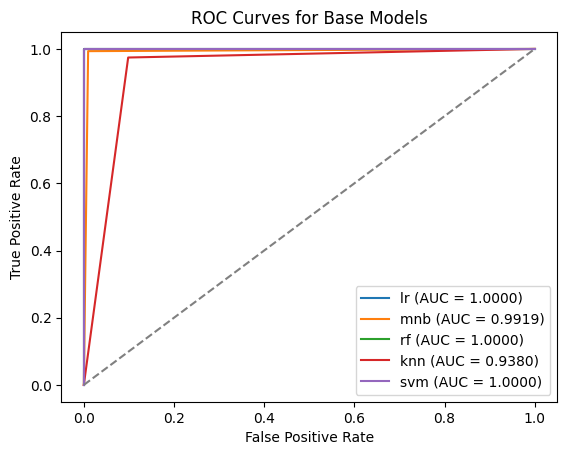

In [232]:
# Create an empty DataFrame for storing metrics
metrics_df_train = pd.DataFrame(index=base_names + ['Stacking Model'], columns=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'])

# Access trained base models
trained_base_models = {name: model for name, model in stack.named_estimators_.items()}

# Initialize lists to store ROC curve data
plt.figure()

# Evaluate each trained base model
for name, model in trained_base_models.items():
    y_pred = model.predict(X_train_tfidf)
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_train, y_pred)
    precision = precision_score(y_train, y_pred)
    recall = recall_score(y_train, y_pred)
    f1 = f1_score(y_train, y_pred)
    roc_auc = roc_auc_score(y_train, y_pred)
    
    # Print evaluation metrics
    print(f"{name}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-score: {f1:.4f}")
    print(f"  ROC AUC: {roc_auc:.4f}")
    
    # Store metrics in the DataFrame
    metrics_df_train.loc[name] = [accuracy, precision, recall, f1, roc_auc]
    
    # Print classification report
    print(f"  Classification Report:")
    print(classification_report(y_train, y_pred))
    
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_train, y_pred)

    # Plot ROC curve for each model
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f})')

# Plot ROC curve for random guessing (baseline)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

# Customize plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Base Models')
plt.legend()
plt.show()

Metrics for Stacking Model:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
AUC: 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1047
           1       1.00      1.00      1.00      1056

    accuracy                           1.00      2103
   macro avg       1.00      1.00      1.00      2103
weighted avg       1.00      1.00      1.00      2103



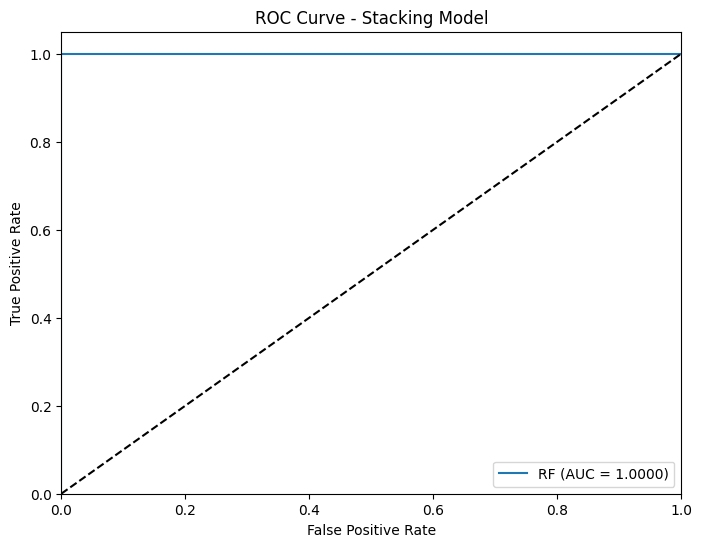

In [233]:
# Evaluate stacking model on training data
stack_y_pred_train = stack.predict(X_train_tfidf)
stack_y_prob_train = stack.predict_proba(X_train_tfidf)[:, 1]  # Probability for positive class for ROC curve

stack_accuracy_train = accuracy_score(y_train, stack_y_pred_train)
stack_precision_train = precision_score(y_train, stack_y_pred_train)
stack_recall_train = recall_score(y_train, stack_y_pred_train)
stack_f1_train = f1_score(y_train, stack_y_pred_train)
stack_auc_train = roc_auc_score(y_train, stack_y_prob_train)

print("Metrics for Stacking Model:")
print(f"Accuracy: {stack_accuracy_train:.4f}")
print(f"Precision: {stack_precision_train:.4f}")
print(f"Recall: {stack_recall_train:.4f}")
print(f"F1 Score: {stack_f1_train:.4f}")
print(f"AUC: {stack_auc_train:.4f}")
print(f"Classification Report:\n{classification_report(y_train, stack_y_pred_train)}")

# ROC Curve for stacking model
stack_fpr, stack_tpr, _ = roc_curve(y_train, stack_y_prob_train)
stack_roc_auc = roc_auc_score(y_train, stack_y_prob_train)

# Store stacking model metrics in the DataFrame
metrics_df_train.loc['Stacking Model'] = [stack_accuracy_train, stack_precision_train, stack_recall_train, stack_f1_train, stack_auc_train]

# Plot ROC Curve for stacking model
plt.figure(figsize=(8, 6))
plt.plot(stack_fpr, stack_tpr, label=f'RF (AUC = {stack_roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Stacking Model')
plt.legend(loc="lower right")
plt.show()

In [234]:
# Display the comparison table
print("Comparison of Models:")
print(metrics_df_train)

Comparison of Models:
                Accuracy Precision    Recall  F1 Score       AUC
lr                   1.0       1.0       1.0       1.0       1.0
mnb             0.991916  0.990557  0.993371  0.991962   0.99191
rf                   1.0       1.0       1.0       1.0       1.0
knn             0.938184  0.909011  0.974432  0.940585  0.938028
svm                  1.0       1.0       1.0       1.0       1.0
Stacking Model       1.0       1.0       1.0       1.0       1.0


lr:
  Accuracy: 93.90
  Precision: 96.06
  Recall: 91.61
  F1-score: 93.79
  ROC AUC: 93.91
  Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       449
           1       0.96      0.92      0.94       453

    accuracy                           0.94       902
   macro avg       0.94      0.94      0.94       902
weighted avg       0.94      0.94      0.94       902

mnb:
  Accuracy: 91.24
  Precision: 89.29
  Recall: 93.82
  F1-score: 91.50
  ROC AUC: 91.23
  Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91       449
           1       0.89      0.94      0.91       453

    accuracy                           0.91       902
   macro avg       0.91      0.91      0.91       902
weighted avg       0.91      0.91      0.91       902

rf:
  Accuracy: 92.68
  Precision: 93.48
  Recall: 91.83
  F1-score: 92.65
  ROC AUC: 92.69
  Classification Re

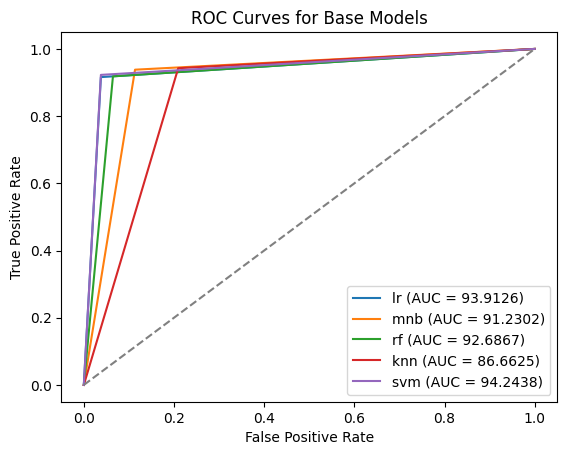

In [235]:
# Create an empty DataFrame for storing metrics
metrics_df = pd.DataFrame(index=base_names + ['Stacking Model'], columns=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'])

# Access trained base models
trained_base_models = {name: model for name, model in stack.named_estimators_.items()}

# Initialize lists to store ROC curve data
plt.figure()

# Evaluate each trained base model
for name, model in trained_base_models.items():
    y_pred = model.predict(X_test_tfidf)
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)*100
    precision = precision_score(y_test, y_pred)*100
    recall = recall_score(y_test, y_pred)*100
    f1 = f1_score(y_test, y_pred)*100
    roc_auc = roc_auc_score(y_test, y_pred)*100
    
    # Print evaluation metrics
    print(f"{name}:")
    print(f"  Accuracy: {accuracy:.2f}")
    print(f"  Precision: {precision:.2f}")
    print(f"  Recall: {recall:.2f}")
    print(f"  F1-score: {f1:.2f}")
    print(f"  ROC AUC: {roc_auc:.2f}")
    
    # Store metrics in the DataFrame
    metrics_df.loc[name] = [accuracy, precision, recall, f1, roc_auc]
    
    # Print classification report
    print(f"  Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred)

    # Plot ROC curve for each model
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f})')

# Plot ROC curve for random guessing (baseline)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

# Customize plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Base Models')
plt.legend()
plt.show()

Metrics for Stacking Model:
Accuracy: 94.79
Precision: 95.52
Recall: 94.04
F1 Score: 94.77
AUC: 98.44
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       449
           1       0.96      0.94      0.95       453

    accuracy                           0.95       902
   macro avg       0.95      0.95      0.95       902
weighted avg       0.95      0.95      0.95       902



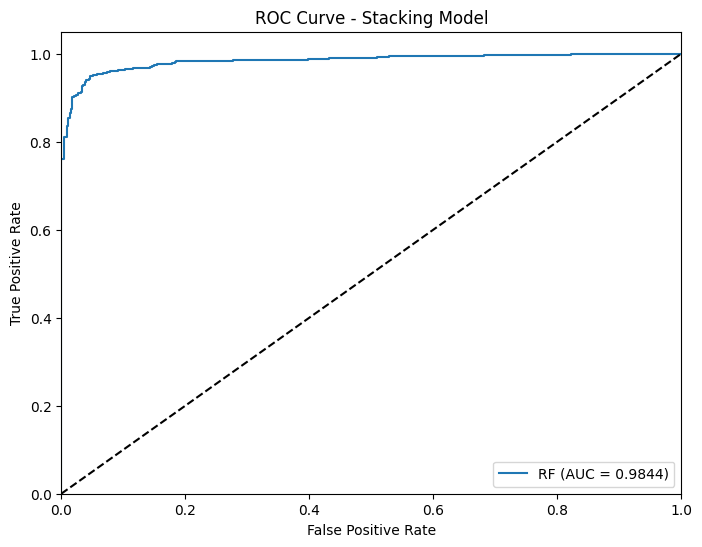

In [236]:
# Evaluate stacking model
stack_y_pred = stack.predict(X_test_tfidf)
stack_y_prob = stack.predict_proba(X_test_tfidf)[:, 1]  # Probability for positive class for ROC curve

stack_accuracy = accuracy_score(y_test, stack_y_pred)*100
stack_precision = precision_score(y_test, stack_y_pred)*100
stack_recall = recall_score(y_test, stack_y_pred)*100
stack_f1 = f1_score(y_test, stack_y_pred)*100
stack_auc = roc_auc_score(y_test, stack_y_prob)*100

print("Metrics for Stacking Model:")
print(f"Accuracy: {stack_accuracy:.2f}")
print(f"Precision: {stack_precision:.2f}")
print(f"Recall: {stack_recall:.2f}")
print(f"F1 Score: {stack_f1:.2f}")
print(f"AUC: {stack_auc:.2f}")
print(f"Classification Report:\n{classification_report(y_test, stack_y_pred)}")

# ROC Curve for stacking model
stack_fpr, stack_tpr, _ = roc_curve(y_test, stack_y_prob)
stack_roc_auc = roc_auc_score(y_test, stack_y_prob)

# Store stacking model metrics in the DataFrame
metrics_df.loc['Stacking Model'] = [stack_accuracy, stack_precision, stack_recall, stack_f1, stack_auc]


# Plot ROC Curve for stacking model
plt.figure(figsize=(8, 6))
plt.plot(stack_fpr, stack_tpr, label=f'RF (AUC = {stack_roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Stacking Model')
plt.legend(loc="lower right")
plt.show()

In [237]:
# Display the comparison table
print("Comparison of Models:")
print(metrics_df)

Comparison of Models:
                 Accuracy  Precision     Recall   F1 Score        AUC
lr              93.902439  96.064815  91.611479  93.785311  93.912644
mnb             91.241685  89.285714  93.818985  91.496233  91.230205
rf              92.682927  93.483146   91.83223  92.650334  92.686716
knn             86.696231  81.957774  94.260486  87.679671  86.662537
svm             94.235033  96.091954  92.273731  94.144144   94.24377
Stacking Model  94.789357  95.515695  94.039735  94.771969  98.442455


In [238]:
from sklearn.model_selection import cross_val_score, cross_val_predict


# Evaluate using cross-validation
cv_scores = cross_val_score(stack, X_train_tfidf, y_train, cv=5, scoring='accuracy')
y_pred = cross_val_predict(stack, X_train_tfidf, y_train, cv=5)

# Calculate metrics
accuracy = accuracy_score(y_train, y_pred)
precision = precision_score(y_train, y_pred)
recall = recall_score(y_train, y_pred)
f1 = f1_score(y_train, y_pred)
classification_rep = classification_report(y_train, y_pred)
fpr, tpr, _ = roc_curve(y_train, y_pred)
roc_auc = roc_auc_score(y_train, y_pred)

# Print results
print("Cross-Validation Accuracy:", cv_scores.mean())
print("Overall Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Classification Report:\n", classification_rep)
print("ROC AUC Score:", roc_auc)

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_stacking.py", line 669, in fit
    return super().fit(X, y_encoded, sample_weight)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_stacking.py", line 210, in fit
    check_is_fitted(estimator)
  File "c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py", line 1622, in check_is_fitted
    raise NotFittedError(msg % {"name": type(estimator).__name__})
sklearn.exceptions.NotFittedError: This LogisticRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.


In [ ]:
def evaluate_metrics(y_train, y_pred, model_name):
    # Calculate metrics
    accuracy = accuracy_score(y_train, y_pred)
    precision = precision_score(y_train, y_pred)
    recall = recall_score(y_train, y_pred)
    f1 = f1_score(y_train, y_pred)
    classification_rep = classification_report(y_train, y_pred, output_dict=True)
    roc_auc = roc_auc_score(y_train, y_pred)

    # Create a dictionary to store the metrics
    metrics_dict = {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC Score': roc_auc
    }

    # Convert the dictionary into a pandas DataFrame
    metrics_df = pd.DataFrame(metrics_dict, index=[0])

    return metrics_df

# Create an empty DataFrame to store the evaluation metrics for all models
metrics_df = pd.DataFrame()

# Iterate over the named estimators in the stacking classifier
for name, model in stack.named_estimators_.items():

    y_pred = cross_val_predict(model, X_train_tfidf, y_train, cv=5)
    
    # Evaluate the model and add the metrics to the DataFrame
    model_metrics = evaluate_metrics(y_train, y_pred, name)
    metrics_df = pd.concat([metrics_df, model_metrics], ignore_index=True)

In [ ]:
joblib.dump('../Models/Grid/grid_mlp_3_newvec.joblib')